## Comparing molecule properties against Novartis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

In [2]:
def get_records(path, measure):

    trial_indices = defaultdict(int)
    
    with zipfile.ZipFile(path, 'r') as z:
        for filename in tqdm(z.namelist()):
            if filename.endswith('.json'):
                with z.open(filename) as file:
                    with TextIOWrapper(file, encoding='utf-8') as text_file:
                        try:
                            result = json.load(text_file)
                            record = pd.DataFrame(
                                result['annotations']
                            ).reindex(
                                columns=['SMILES', 'Step Made', 'ABL1 pIC50', 'Log P', 'Log S']
                            ).dropna()

                            value = result[measure]
                            
                            if value == 4:
                                trial_indices[value] += 1
                                record[measure] = value
                                record['trial'] = trial_indices[value]

                                records.append(record)
                                result = None
                        except:
                            continue
    return records

paths = [
    '../../dgym-data/analysis/temperature/selection_temperature_2024-05-03_11-15-29.zip',
]

measure = 'temperature_index'
records = []
for path in paths:
    records.extend(get_records(path, measure))

df_raw = pd.concat(records)
records = None

  0%|          | 0/2100 [00:00<?, ?it/s]

# Load data from disk

`Temperature = 0.16`

In [52]:
import pandas as pd
df_raw = pd.read_csv('../../dgym-data/analysis/novartis/trajectories.csv', index_col=0)

Assigning outcomes.

In [53]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction([
    docking_utility_function, log_P_utility_function, log_S_utility_function])

In [54]:
from tqdm.auto import tqdm

records = []
for trial, data in tqdm(df_raw.groupby('trial')):
    utility = composite_utility_function(
        data.reindex(columns=['ABL1 pIC50', 'Log P', 'Log S']).values,
        precompute=True,
        method='average'
    )
    try:
        cost = utility.index(1.0)
        outcome = 1
    except:
        cost = len(utility)
        outcome = 0

    data['outcome'] = outcome
    records.append(data)
    
df = pd.concat(records).query('outcome == 1')

  0%|          | 0/100 [00:00<?, ?it/s]

Featurize.

In [ ]:
'ExactMolWt', 'FpDensityMorgan1',
'HeavyAtomMolWt', 'MinPartialCharge', 'MolWt',
'MolLogP', 'FractionCSP3',
'HeavyAtomCount', 'NumAliphaticCarbocycles',
'NumAliphaticHeterocycles', 'NumAliphaticRings',
'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
'NumAromaticRings', 'NumHAcceptors',
'NumHDonors', 'NumHeteroatoms',
'NumRotatableBonds', 'NumSaturatedCarbocycles',
'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount',

In [82]:
from tqdm.auto import tqdm
from scikit_mol.conversions import SmilesToMolTransformer
from scikit_mol.descriptors import MolecularDescriptorTransformer

smiles_to_mol = SmilesToMolTransformer(parallel=True)

desc_list = [
    'HeavyAtomCount',
    'FractionCSP3',
    # 'NumAtomStereoCenters',
    'NumRotatableBonds',
    'TPSA',
    'RingCount',
    'NumAliphaticRings',
    'NumAromaticRings',
    'NOCount',
    # 'NumHalogen',
    'NHOHCount',
    # 'NumAmideBonds',
]
featurizer = MolecularDescriptorTransformer(
    desc_list, parallel=True)

trial_data = []
for trial, data in tqdm(df.groupby('trial')):
    rd_mols = smiles_to_mol.transform(data['SMILES'].values)
    X = featurizer.transform(rd_mols)
    
    for (label, features) in zip(desc_list, X.T):
        data[label] = features
    
    # Convert step made to Progress of Series as in Novartis paper.
    data['Progress'] = data['Step Made'] / data['Step Made'].max() * 100

    trial_data.append(data)
    
mol_properties = pd.concat(trial_data)

  0%|          | 0/87 [00:00<?, ?it/s]

In [83]:
mol_properties['LE'] = 1.4 * mol_properties['ABL1 pIC50'] / mol_properties['HeavyAtomCount']

In [86]:
for descriptor in desc_list[2:]:
    mol_properties[f'{descriptor}/1000 atoms'] = \
        mol_properties[descriptor] / mol_properties['HeavyAtomCount'] * 1000

Plotting

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

Text(0.5, 1.0, 'Evolution of chemical properties over repeated trials')

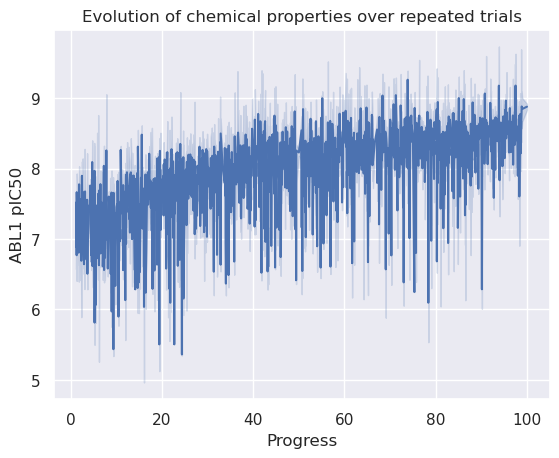

In [123]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.lineplot(
    data=mol_properties,
    x='Step Made',
    y='ABL1 pIC50',
    estimator=lambda x: np.quantile(x, 0.90)
)

plt.title('Evolution of chemical properties over repeated trials')

Using faceting.

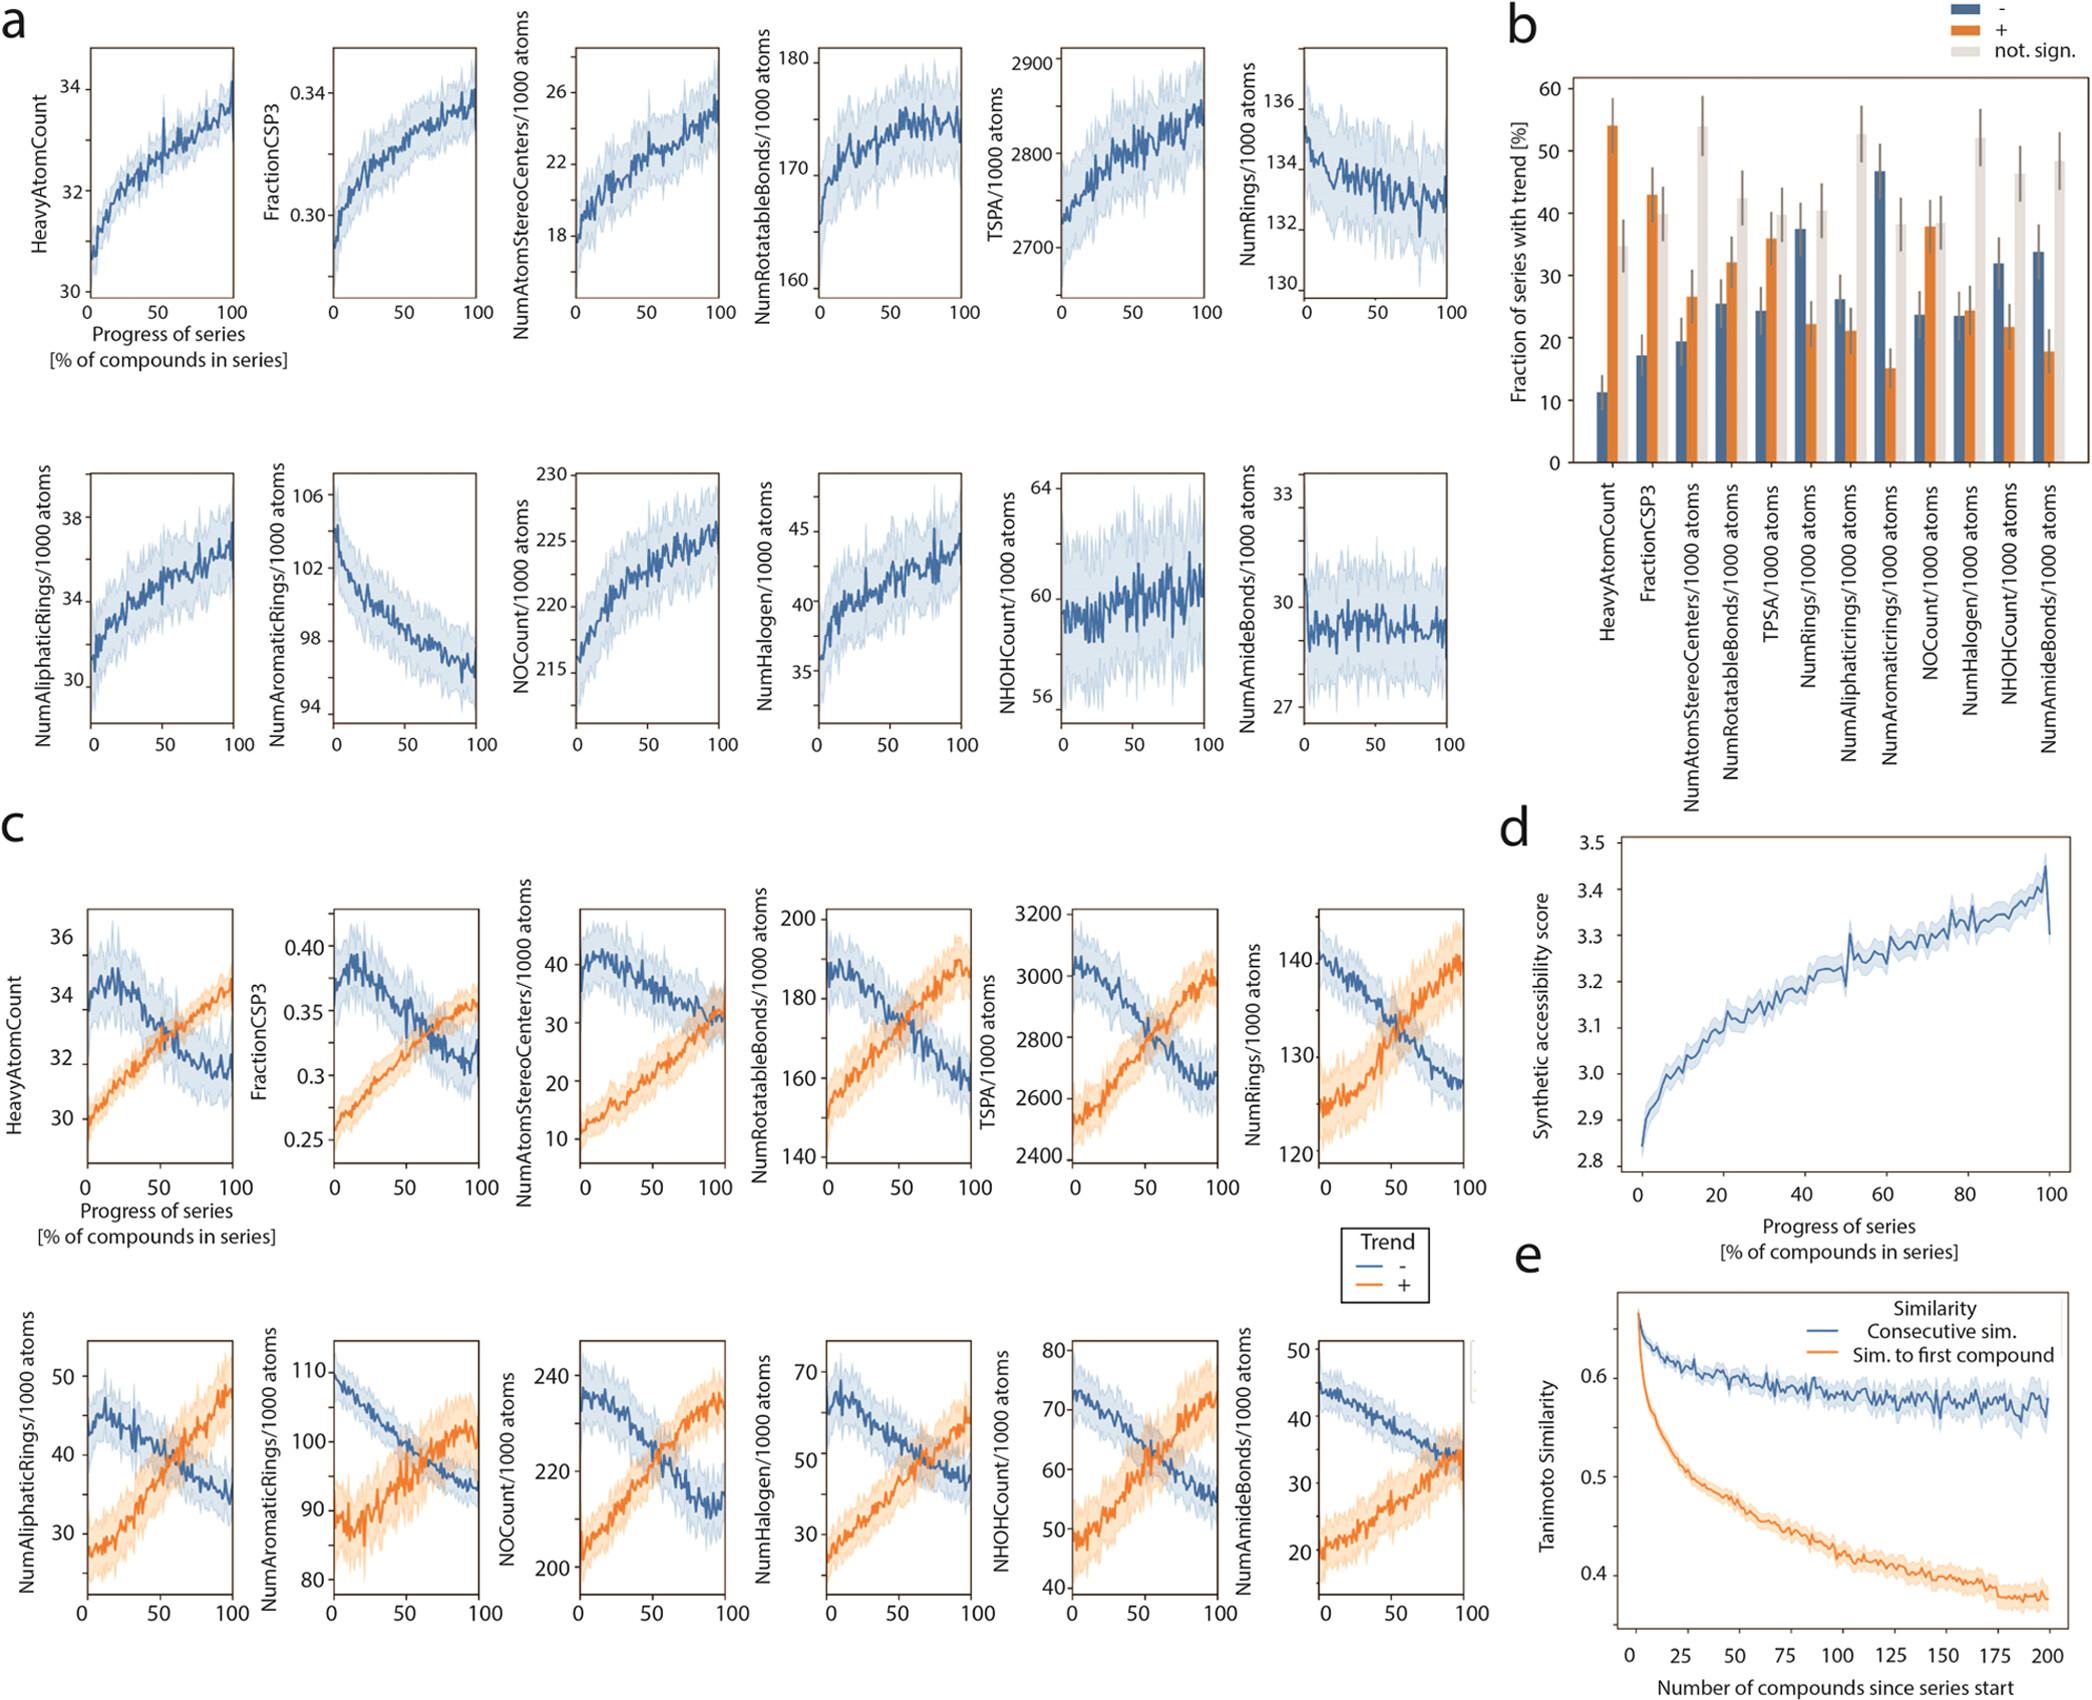

In [102]:
columns = [f'{d}/1000 atoms' if d not in ['HeavyAtomCount', 'FractionCSP3'] else d for d in desc_list]
columns.append('SMILES')
columns.append('Progress')

In [113]:
# Assuming your dataframe is named df
long_df = pd.melt(
    mol_properties.reindex(columns=columns),
    id_vars=['SMILES', 'Progress'],
    var_name='Property',
    value_name='Value'
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will 

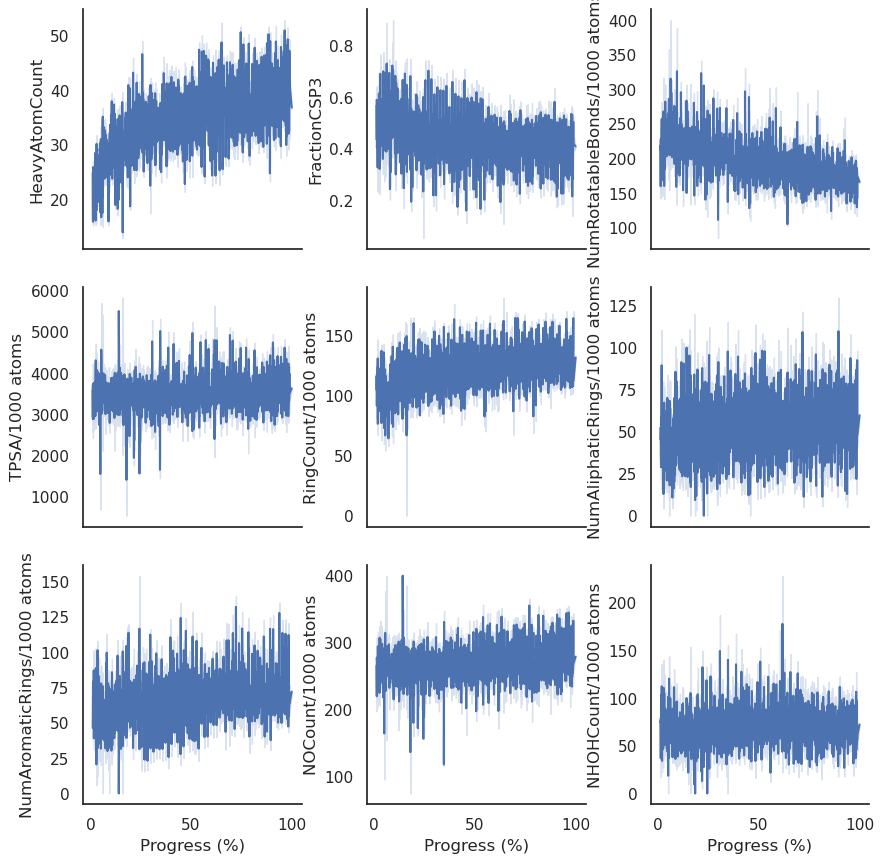

In [119]:
sns.set_style('white')

g = sns.FacetGrid(long_df, col='Property', col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, x='Progress', y='Value')

g.set_titles("")
g.set_axis_labels("Progress (%)", "")
g.set(xticks=[0, 50, 100])

# Set the property name as y-axis label
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_ylabel(title)